In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPool2D, LeakyReLU
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import os
import math
import matplotlib.pyplot as plt 
import numpy as np
import scipy.ndimage as ndimage

ModuleNotFoundError: No module named 'tensorflow_addons'

In [2]:
image_dir_blur = "deblur detection/images/train/A/"
image_dir_clear = "deblur detection/images/train/B/"
image_paths_blur = os.listdir(image_dir_blur)
image_paths_clear = [image_dir_clear+path for path in image_paths_blur]
image_paths_blur = [image_dir_blur+path for path in image_paths_blur]

In [3]:
image_shape = (720, 1280)
every_n_image = 6
with tf.device("CPU:0"):
  # Load the data into memory
  blur_images = tf.zeros([1, *image_shape, 3], dtype="uint8")
  clear_images = tf.zeros([1, *image_shape, 3], dtype="uint8")
  for i in range(len(image_paths_clear)):
    
    blur_image_path = image_paths_blur[i*every_n_image]
    clear_image_path = image_paths_clear[i*every_n_image]
    
    blur_image = tf.image.decode_png(tf.io.read_file(blur_image_path))[tf.newaxis]
    blur_images = tf.concat([blur_image, blur_images], axis=0)

    clear_image = tf.image.decode_png(tf.io.read_file(clear_image_path))[tf.newaxis]
    clear_images = tf.concat([clear_image, clear_images], axis=0)

    if (i+1)%30==0:
      print("Retrieved %d images" % (i+1))
    
    if (i+1)*every_n_image>=len(image_paths_clear):
      break

Retrieved 30 images
Retrieved 60 images
Retrieved 90 images
Retrieved 120 images
Retrieved 150 images
Retrieved 180 images
Retrieved 210 images
Retrieved 240 images
Retrieved 270 images
Retrieved 300 images
Retrieved 330 images


In [4]:
# create the dataset
epoch_size = len(blur_images)

dataset = tf.data.Dataset.from_tensor_slices((blur_images, clear_images))
dataset = dataset.repeat().shuffle(epoch_size)

resize_shape = (128, 128)

height, width = clear_image.shape[1:3]
max_crop = min(height, width)

def random_rotate_image(blur_image, clear_image):
  angle = np.random.uniform(-30, 30)
  clear_image = ndimage.rotate(clear_image, angle, reshape=False)
  blur_image = ndimage.rotate(blur_image, angle, reshape=False)
  return blur_image, clear_image

def random_crop_image(blur_image, clear_image):
    random_value = np.random.choice(range(32, max_crop))
    height_random_value = np.random.choice(range(height-random_value))
    width_random_value = np.random.choice(range(width-random_value))

    out = tf.stack([blur_image, clear_image])

    out = out[:, height_random_value:(height_random_value+random_value), width_random_value:(width_random_value+random_value)]
    out = tf.image.resize(out, resize_shape)
    return out

def crop_and_resize_image(blur_image, clear_image):

  [out, ] = tf.py_function(random_crop_image, [blur_image, clear_image], [tf.float32])
  [blur_image, clear_image] = tf.py_function(random_rotate_image, [out[0], out[1]], [tf.float32, tf.float32])
  blur_image = 2*blur_image/255 - 1
  clear_image = 2*clear_image/255 - 1

  return blur_image, clear_image-blur_image

dataset = dataset.map(crop_and_resize_image, num_parallel_calls=4)
dataset = dataset.batch(14)
# try one of the following
dataset = dataset.prefetch(4)

In [5]:

for data in dataset:
  print(data[0].shape)
  break

%timeit -n 5 for data in dataset: break

(14, 128, 128, 3)
2.85 s ± 165 ms per loop (mean ± std. dev. of 7 runs, 5 loops each)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

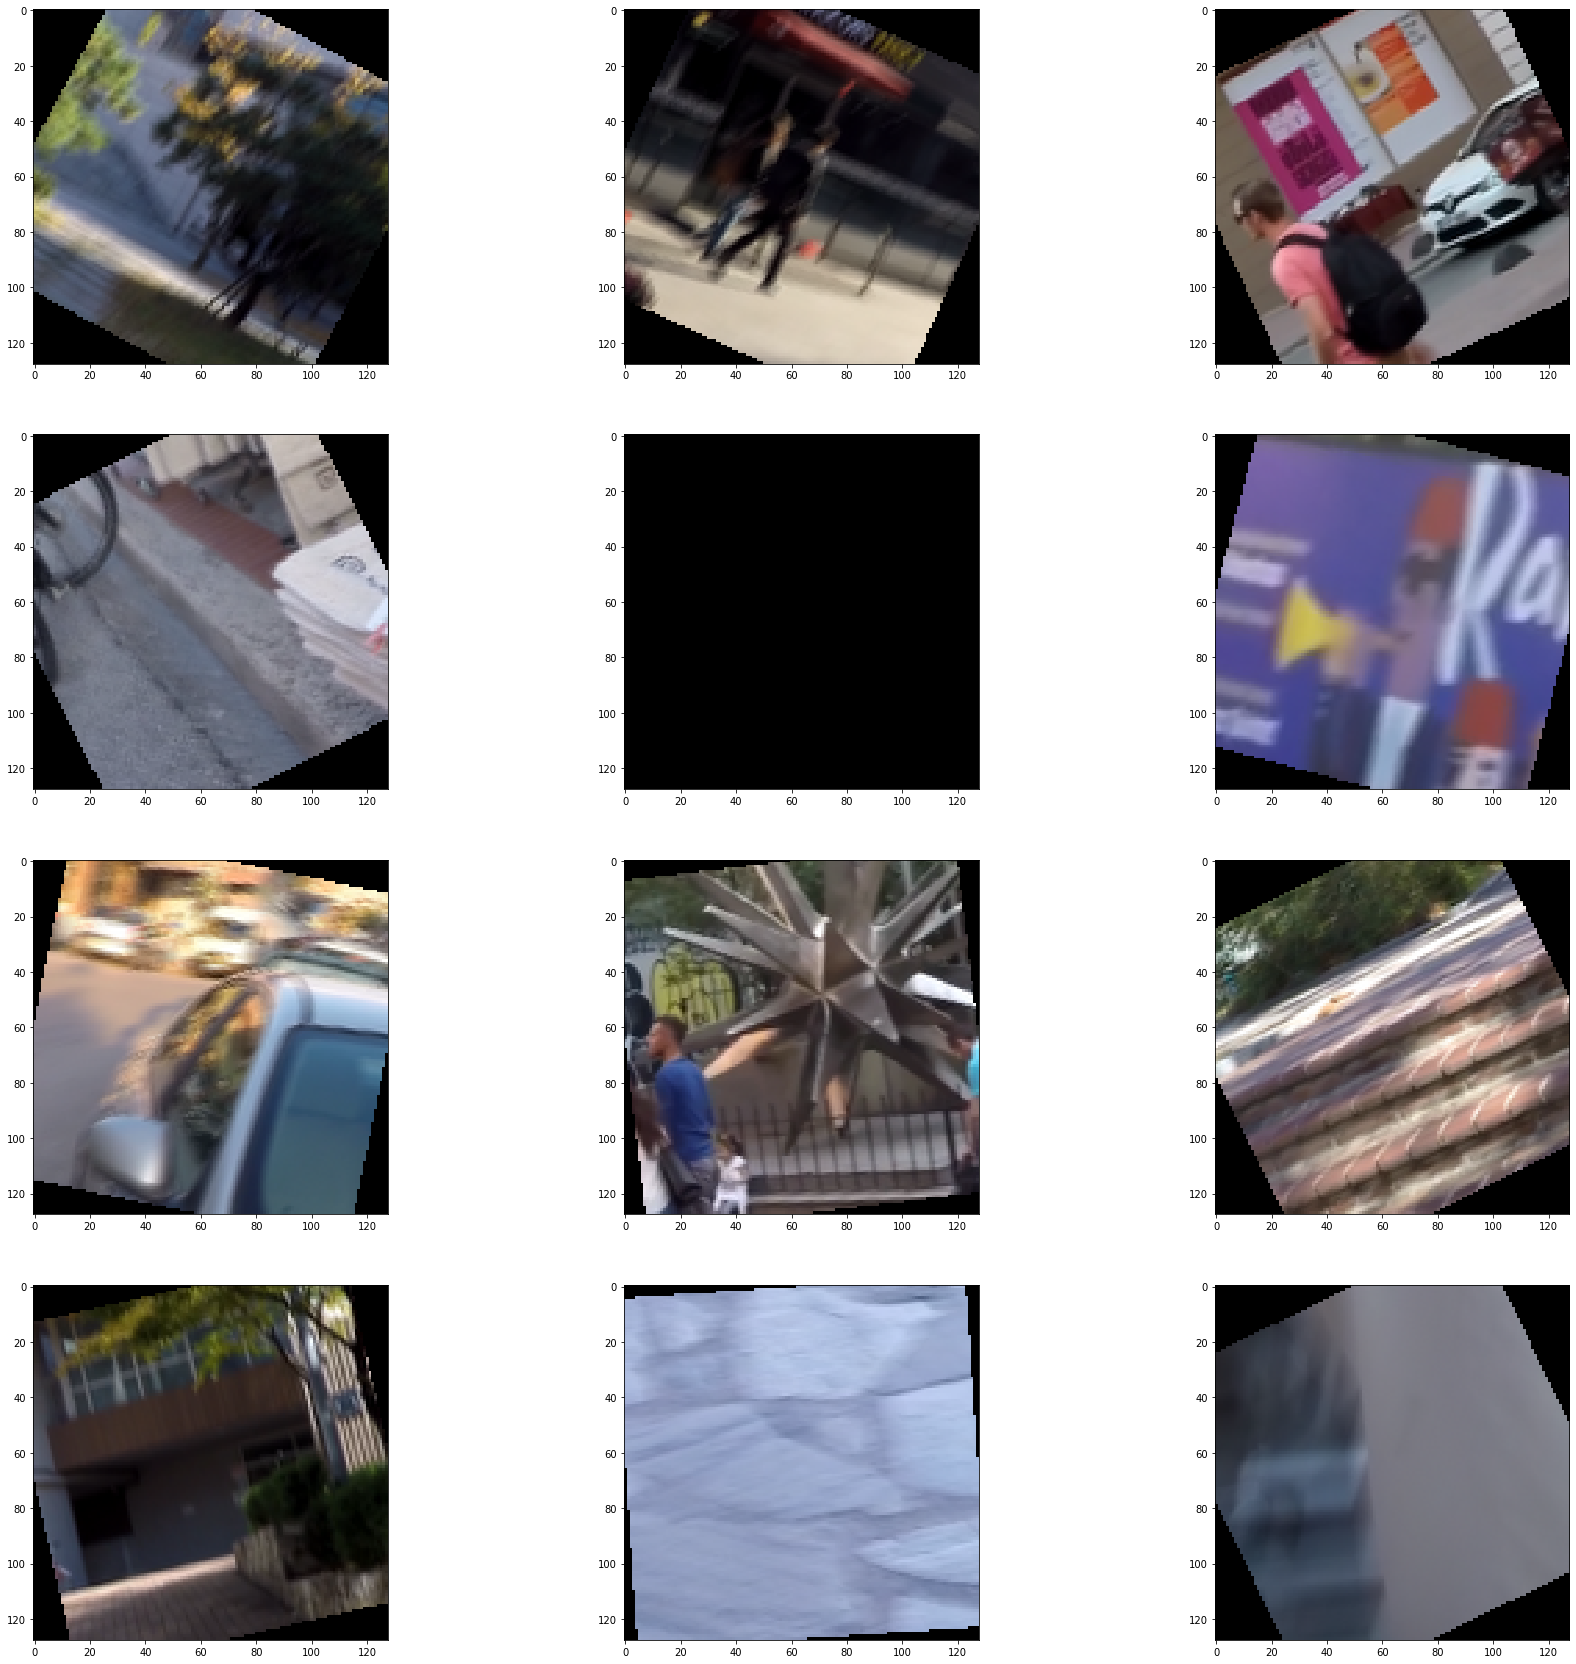

In [6]:
plt.figure()
plt.figure(figsize=(30.0, 30.0))
for i in range(12):
  plt.subplot(4, 3, i+1)
  plt.imshow((data[0][i])/2 + 0.5)
plt.show()

In [7]:
class WeightGenerator(tf.keras.layers.Layer):
    def __init__(self):
        super(WeightGenerator, self).__init__()
        self.vgg_layers = keras.applications.vgg16.VGG16(include_top=False).layers[:13]
        # for layer in self.vgg_layers[:8]:
        #   layer.trainable = False
        self.pool1 = MaxPool2D()
        self.pool2 = MaxPool2D()
        self.pool3 = MaxPool2D()
        self.conv12 = Conv2D(256, 3, padding="same")
        # Determine Resize 2 in build
        # Add the concatenation from conv8 in the call
        self.conv13 = Conv2D(128, 3, padding="same")
        self.conv14 = Conv2D(128, 3, padding="same")
        # Determine Resize 3 in build
        # Add the concatenation from conv6 in the call
        self.conv15 = Conv2D(128, 3, strides=2, padding="same")
        self.conv16 = Conv2D(512, 3, padding="same")
        
        # All the layers have ReLU function, except for the last layer where we use tanh
        
    # def build(self, input_shape):
    #     height, width = input_shape[1:3]
    #     self.resize2_size = tf.convert_to_tensor([(height//2)//2, (width//2)//2], dtype="int32")
    #     self.resize3_size = self.resize2_size * 2
    
    @tf.function
    def call(self, inputs):
        x = self.vgg_layers[1](inputs)
        x = tf.nn.relu(x)
        x = self.vgg_layers[2](x)
        x = tf.nn.relu(x)
        x = self.pool1(x)
        x = self.vgg_layers[4](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[5](x)
        x1 = tf.nn.relu(x)
        x = self.pool2(x1)
        x = self.vgg_layers[7](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[8](x)
        x2 = tf.nn.relu(x)
        x = self.vgg_layers[9](x)
        x = tf.nn.relu(x)
        x = self.pool3(x)
        x = self.vgg_layers[11](x)
        x = tf.nn.relu(x)
        x = self.vgg_layers[12](x)
        x = tf.nn.relu(x)

        x = self.conv12(x)
        x = tf.nn.relu(x)
        x = tf.image.resize(x, tf.convert_to_tensor(x.shape[1:3])*2)
        x = tf.concat([x, x2], axis=3)
        x = self.conv13(x)
        x = tf.nn.relu(x)
        x = self.conv14(x)
        x = tf.nn.relu(x)
        x = tf.image.resize(x, tf.convert_to_tensor(x.shape[1:3])*2)
        x = tf.concat([x, x1], axis=3)
        x = self.conv15(x)
        x = tf.nn.relu(x)
        x = self.conv16(x)
        x = tf.nn.tanh(x)
        return x

In [8]:
# The features should have depth hidden_vector_dimension. The features should have 2*hidden_vector_dimension. The first half is used for the height, and the second half for the width
class RNN_Spatial(tf.keras.layers.Layer):
  def __init__(self):
    super(RNN_Spatial, self).__init__()

  def build(self, input_shape):
    feature_shape, weight_shape = input_shape
    self.depth = feature_shape[3]
    self.height, self.width = feature_shape[1:3]
    # self.height, self.width = tf.convert_to_tensor(self.height), tf.convert_to_tensor(self.width)
  
  def height_forward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)

    new_k = (1 - weights[:, 0, None, :, :]) * features[:, 0, None, :, :] + weights[:, 0, None, :, :]*hidden_vector
    for i in range(1, self.height):
      hidden_vector = (1 - weights[:, i, None, :, :]) * features[:, i, None, :, :] + weights[:, i, None, :, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=1)
    return new_k

  # the features for this are different from the forward pass
  def height_backward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)

    new_k = (1 - weights[:, self.height-1, None, :, :]) * features[:, self.height-1, None, :, :] + weights[:, self.height-1, None, :, :]*hidden_vector
    for i in range(1, self.height):
      hidden_vector = (1 - weights[:, self.height-i-1, None, :, :]) * features[:, self.height-i-1, None, :, :] + weights[:, self.height-i-1, None, :, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=1)
    return new_k

  def width_forward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)
    
    new_k = (1 - weights[:, :, None, 0, :]) * features[:, :, None, 0, :] + weights[:, :, None, 0, :]*hidden_vector
    for i in range(1, self.width):
      hidden_vector = (1 - weights[:, :, None, i, :]) * features[:, :, None, i, :] + weights[:, :, None, i, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=2)
    return new_k

  def width_backward(self, features, weights):
    hidden_vector = tf.zeros(self.depth)
    
    new_k = (1 - weights[:, :, None, self.width-1, :]) * features[:, :, None, self.width-1, :] + weights[:, :, None, self.width-1, :]*hidden_vector
    for i in range(1, self.width):
      hidden_vector = (1 - weights[:, :, None, self.width-i-1, :]) * features[:, :, None, self.width-i-1, :] + weights[:, :, None, self.width-i-1, :]*hidden_vector
      new_k = tf.concat([new_k, hidden_vector], axis=2)
    return new_k

  @tf.function
  def call(self, inputs):
    features, weights = inputs

    self.height, self.width = features.shape[1:3]

    h_f = self.height_forward(features, weights[:, :, :, :self.depth])
    h_b = self.height_backward(features, weights[:, :, :, self.depth:2*self.depth])

    w_f = self.width_forward(features, weights[:, :, :, 2*self.depth:3*self.depth])
    w_b = self.width_backward(features, weights[:, :, :, 3*self.depth:4*self.depth])

    complete = tf.stack([h_f, h_b, w_f, w_b])
    out = tf.reduce_max(complete, axis=0)
    return out

In [9]:
class CompleteModel(tf.keras.Model):
  def __init__(self):
    super(CompleteModel, self).__init__()
    self.weight_generator = WeightGenerator()
    self.conv1 = Conv2D(16, 11, padding="same")
    self.conv2 = Conv2D(32, 7, strides=(2, 2), padding="same")
    self.conv_new_1 = Conv2D(32, 7, strides=(2, 2), padding="same")
    self.rnn_1 = RNN_Spatial()
    self.rnn_2 = RNN_Spatial()
    self.rnn_3 = RNN_Spatial()
    self.rnn_4 = RNN_Spatial()
    self.conv17 = Conv2D(32, 3, padding="same")
    self.conv18 = Conv2D(32, 3, padding="same")
    self.conv19 = Conv2D(32, 3, padding="same")
    self.conv20 = Conv2D(32, 3, padding="same")
    self.conv_new_2 = Conv2D(16, 7, padding="same")
    self.conv21 = Conv2D(16, 9, padding="same")
    self.conv22 = Conv2D(3, 5, padding="same")

  # def build(self, input_shape):
  #   height, width = input_shape[1:3]
  #   self.resize1 = tf.convert_to_tensor([height, width], dtype="int32")
  #   self.resize_new = self.resize1//2

  @ tf.function 
  def call(self, input_images):
    weights = self.weight_generator(input_images)
    x = self.conv1(input_images)
    x1 = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.conv2(x1)
    x2 = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.conv_new_1(x2)
    x3 = tf.nn.leaky_relu(x, alpha=0.1)

    x = self.rnn_1([x3, weights[:, :, :, :32*4]]) # x3 to switch back
    x = self.conv17(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_2([x, weights[:, :, :, 32*4:32*8]])
    x = self.conv18(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_3([x, weights[:, :, :, 32*8:32*12]])
    x = self.conv19(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = self.rnn_4([x, weights[:, :, :, 32*12:32*16]])
    x = self.conv20(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)

    x = tf.concat([x, x3], axis=3)
    x = self.conv_new_2(x)
    x = tf.nn.leaky_relu(x,  alpha=0.1)
    x = tf.image.resize(x, 2*tf.convert_to_tensor(x.shape[1:3]))

    x = tf.concat([x, x2], axis=3)
    x = self.conv21(x)
    x = tf.nn.leaky_relu(x, alpha=0.1)
    x = tf.image.resize(x, 2*tf.convert_to_tensor(x.shape[1:3]))


    x = tf.concat([x, x1], axis=3)
    x = self.conv22(x)
    return x

In [10]:
weight_path = "weights/weight_custom_0.3"
complete_model = CompleteModel()
complete_model.load_weights(weight_path)
optim = tf.keras.optimizers.Adam(0.0001, 0.9, 0.999, 1e-6)
test = complete_model(data[0])
params = complete_model.trainable_variables

In [11]:
@tf.function
def train_step(blur_clear):
  with tf.GradientTape() as tape:
    out = complete_model(blur_clear[0]) # blur_clear
    loss = tf.reduce_mean((out-blur_clear[1])**2) # blur_clear
    grads = tape.gradient(loss, params)
    optim.apply_gradients(zip(grads, params))
    return loss

def train():
  total_loss = 0
  for i, blur_clear in enumerate(dataset):
      total_loss += train_step(blur_clear)

      if (i+1)%10000==0:
        complete_model.save_weights("weights/weight_%d_%.4f" % (i+1, total_loss))
        print("saved weights to weights/weight_%d_%.4f" % (i+1, total_loss))

      if (i+1)%50==0:
        print("Epoch : %d Iteration %d loss : %.5f" % (i*20//epoch_size, i+1, total_loss))
        total_loss = 0

      if i==200000:
        break

      if i==0:
        print("Hooray! Off we go!")

In [ ]:
with tf.device("GPU:0"):
    train()

Hooray! Off we go!
Epoch : 2 Iteration 50 loss : 0.32724
Epoch : 5 Iteration 100 loss : 0.30505
Epoch : 8 Iteration 150 loss : 0.33265
Epoch : 11 Iteration 200 loss : 0.32429
Epoch : 14 Iteration 250 loss : 0.32462
Epoch : 16 Iteration 300 loss : 0.31830
Epoch : 19 Iteration 350 loss : 0.32709
Epoch : 22 Iteration 400 loss : 0.31639
Epoch : 25 Iteration 450 loss : 0.30115
Epoch : 28 Iteration 500 loss : 0.30786
Epoch : 31 Iteration 550 loss : 0.31117
Epoch : 34 Iteration 600 loss : 0.30789
Epoch : 36 Iteration 650 loss : 0.34674
Epoch : 39 Iteration 700 loss : 0.32345
Epoch : 42 Iteration 750 loss : 0.32086
Epoch : 45 Iteration 800 loss : 0.34152
Epoch : 48 Iteration 850 loss : 0.31651
Epoch : 51 Iteration 900 loss : 0.36318
Epoch : 53 Iteration 950 loss : 0.30486
Epoch : 56 Iteration 1000 loss : 0.34057
Epoch : 59 Iteration 1050 loss : 0.34681
Epoch : 62 Iteration 1100 loss : 0.32127
Epoch : 65 Iteration 1150 loss : 0.34240
Epoch : 68 Iteration 1200 loss : 0.29781
Epoch : 70 Iteration

Epoch : 559 Iteration 9850 loss : 0.30654
Epoch : 562 Iteration 9900 loss : 0.32202
Epoch : 565 Iteration 9950 loss : 0.31454
saved weights to weights/weight_10000_0.2911
Epoch : 568 Iteration 10000 loss : 0.29109
Epoch : 570 Iteration 10050 loss : 0.34829
Epoch : 573 Iteration 10100 loss : 0.32958
Epoch : 576 Iteration 10150 loss : 0.30339
Epoch : 579 Iteration 10200 loss : 0.32152
Epoch : 582 Iteration 10250 loss : 0.33968
Epoch : 585 Iteration 10300 loss : 0.30782
Epoch : 588 Iteration 10350 loss : 0.31810
Epoch : 590 Iteration 10400 loss : 0.32367
Epoch : 593 Iteration 10450 loss : 0.31091
Epoch : 596 Iteration 10500 loss : 0.31026
Epoch : 599 Iteration 10550 loss : 0.31447
Epoch : 602 Iteration 10600 loss : 0.34629
Epoch : 605 Iteration 10650 loss : 0.31341
Epoch : 607 Iteration 10700 loss : 0.30345
Epoch : 610 Iteration 10750 loss : 0.33832
Epoch : 613 Iteration 10800 loss : 0.33026
Epoch : 616 Iteration 10850 loss : 0.35078
Epoch : 619 Iteration 10900 loss : 0.30633
Epoch : 622 

# Miscellaneous Tests

In [ ]:
image_dir_blur_test = "deblur detection/images/test/A/"
image_dir_clear_test = "deblur detection/images/test/B/"
image_paths_blur_test = os.listdir(image_dir_blur_test)
image_paths_clear_test = [image_dir_clear_test+path for path in image_paths_blur_test]
image_paths_blur_test = [image_dir_blur_test+path for path in image_paths_blur_test]

In [ ]:
image_no = 800
file_name = "test_images/test_2.jpg"
blur_image = tf.image.decode_png(tf.io.read_file(file_name))[:, :, :3] 
# image_paths_blur_test[image_no]
# clear_image = tf.image.decode_png(tf.io.read_file(image_paths_clear_test[image_no]))

test = tf.cast(blur_image, "float32")
test = 2*test/255 - 1
height, width = test.shape[0:2]
width = (width//16)*16
height = (height//16)*16
# test = test[height//3:height//2, 0:width//2]
test = tf.image.resize(test, (height//2, width//2))
# test = tf.image.resize(test, (144, 256))

# test_result = tf.cast(clear_image, "float32")
# test_result = 2*test_result/255 - 1
# test_result = tf.image.resize(test_result, (144, 256))
# test, test_result = data[0][5], data[1][5]
result = complete_model.predict(test[tf.newaxis])[0]
# test_new = test + result
# result = complete_model.predict(test_new[tf.newaxis])[0]

plt.figure(figsize=(20.0, 20.0))
plt.subplot(1, 2, 1)
plt.imshow((test+1)/2)
plt.subplot(1, 2, 2)
plt.imshow((result+test+1)/2)
# plt.subplot(1, 3, 3)
# plt.imshow((test_result+1)/2)

In [ ]:
plt.figure(figsize=(10.0, 10.0))
plt.imshow((result+2)/4)

In [ ]:
plt.imshow((test_result-test+2)/4)

In [ ]:
complete_model.save_weights("weights/weight_custom_0.3")

In [ ]:
# %timeit -n 5 complete_model(data[0])

In [ ]:
tf.keras.load_model("weights/comlpete_model_0.40")